In [24]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import scipy.stats as stats
import xarray as xr

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi']= 300

test_frames = xr.open_dataset("test.nc").pr.values.reshape(-1, 64, 64)
sample_frames = torch.load("samples.pt", map_location=torch.device('cpu')).reshape(-1, 64, 64).numpy()

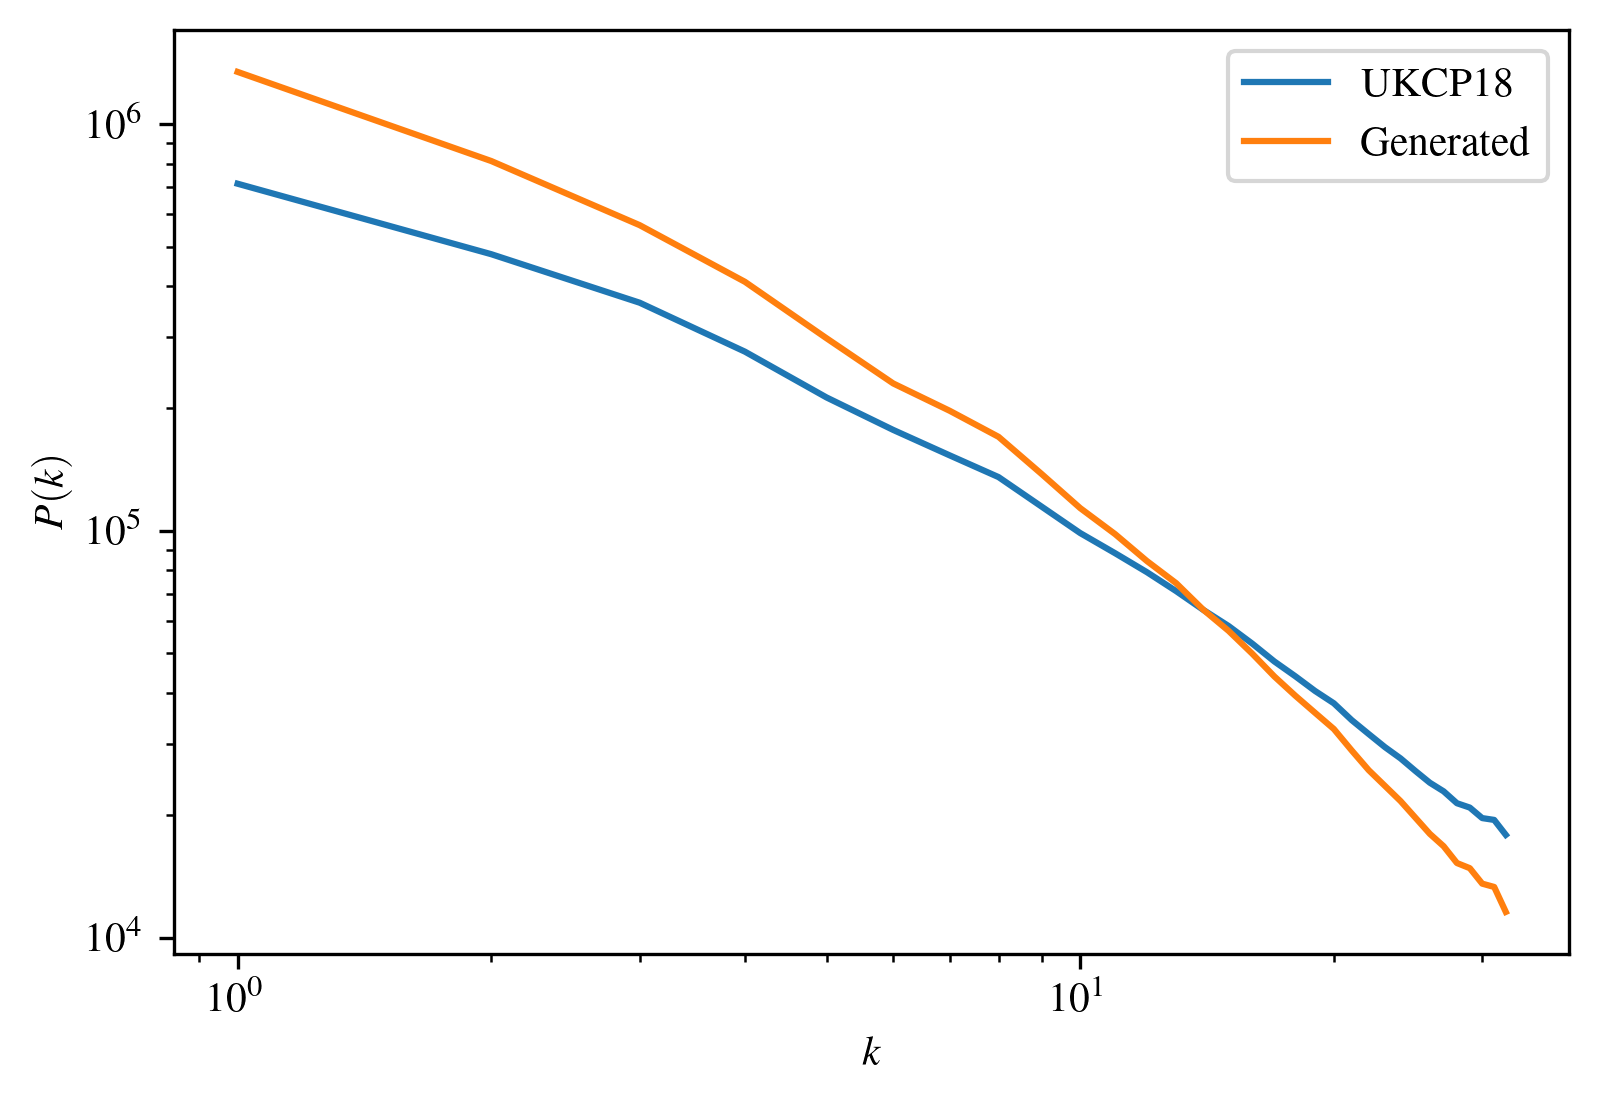

In [25]:
def psd_spatial(frames):
    fourier_image = np.fft.fftn(frames, axes = (1, 2))
    fourier_amplitudes = np.abs(fourier_image) ** 2

    npix = frames.shape[1]

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0] ** 2 + kfreq2D[1] ** 2)
    knrm = knrm.flatten()

    kbins = np.arange(0.5, npix // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic( 
        knrm,
        fourier_amplitudes.reshape(-1, npix * npix), 
        statistic = "mean",
        bins = kbins
    )
    Abins *= np.pi * (kbins[1:] ** 2 - kbins[:-1] ** 2)
    Abins = np.mean(Abins, axis = 0)

    return kvals, Abins

kvals_test, Abins_test = psd_spatial(test_frames)
kvals_sample, Abins_sample = psd_spatial(sample_frames)

plt.figure(figsize=(6, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample, Abins_sample, label="Generated")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.show()